In [1]:
import pandas as pd
import numpy as np

from starknet_py.net.account.account import Account
from starknet_py.net.full_node_client import FullNodeClient
from starknet_py.net.models.chains import StarknetChainId
from starknet_py.net.signer.key_pair import KeyPair
from starknet_py.net.signer.stark_curve_signer import StarkCurveSigner
from starknet_py.contract import Contract

from cauchy_simulations import CauchyLiquidityProfile, ModifiedCauchyLiquidityProfile, from_bps_tick

In [2]:
client = FullNodeClient(node_url="https://rpc.starknet.lava.build:443")

In [3]:
account = Account(
    client=client,
    address="0x4321",
    key_pair=KeyPair(private_key=654, public_key=321),
    chain=StarknetChainId.MAINNET,
)

In [4]:
LP_ADDRESS = "0x02c092af07522b08bb5ea00c01698f2a9ca3721b01f20fbfc324afee78c2a41c"
CORE_ADDRESS = "0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b"
PROFILE_ADDRESS = "0x04f927d2f37496baa8d88a3cfcb2c19d88b9067b7f66dfdda5a176e38c025210"

In [5]:
lp_contract = await Contract.from_address(address=LP_ADDRESS, provider=account)

In [6]:
lp_contract.functions.keys()

dict_keys(['get_primary_interface_id', 'create_and_initialize_pool', 'compound_fees', 'add_liquidity', 'remove_liquidity', 'sweep', 'core', 'profile', 'pool_token', 'pool_liquidity_factor', 'pool_reserves', 'pool_minimum_liquidity_factor', 'locked', 'before_initialize_pool', 'after_initialize_pool', 'before_swap', 'after_swap', 'before_update_position', 'after_update_position', 'before_collect_fees', 'after_collect_fees', 'get_owner', 'transfer_ownership', 'replace_class_hash'])

In [7]:
await lp_contract.functions['core'].call()

(OrderedDict([('contract_address',
               158098919692956613592021320609952044916245725306097615271255138786123)]),)

In [8]:
await lp_contract.functions['profile'].call()

(OrderedDict([('contract_address',
               2249471168798056905190965951989853239977978213936081237646262745692077445648)]),)

In [9]:
# WBTC/tBTC 1 bps fee, 0.01 bps spacing pool
pool_key = {
    "token0": 0x03fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac, # token0: WBTC
    "token1": 0x04daa17763b286d1e59b97c283C0b8C949994C361e426A28F743c67bDfE9a32f, # token1: tBTC
    "fee": 34028236692093846346337460743176821, # fee: 1 bps
    "tick_spacing": 1, # tick spacing: 0.01 bps
    "extension": 0x02c092af07522b08bb5ea00c01698f2a9ca3721b01f20fbfc324afee78c2a41c, # extension
}

In [10]:
await lp_contract.functions['pool_reserves'].call(pool_key)

((349369, 4667967017655949),)

In [11]:
core_contract = await Contract.from_address(address=CORE_ADDRESS, provider=account)

In [12]:
core_contract.functions.keys()

dict_keys(['get_primary_interface_id', 'get_protocol_fees_collected', 'get_locker_state', 'get_locker_delta', 'get_pool_price', 'get_pool_liquidity', 'get_pool_fees_per_liquidity', 'get_pool_fees_per_liquidity_inside', 'get_pool_tick_liquidity_delta', 'get_pool_tick_liquidity_net', 'get_pool_tick_fees_outside', 'get_position', 'get_position_with_fees', 'get_saved_balance', 'next_initialized_tick', 'prev_initialized_tick', 'withdraw_all_protocol_fees', 'withdraw_protocol_fees', 'lock', 'forward', 'withdraw', 'save', 'pay', 'load', 'initialize_pool', 'maybe_initialize_pool', 'update_position', 'collect_fees', 'swap', 'accumulate_as_fees', 'set_call_points', 'get_call_points', 'get_owner', 'transfer_ownership', 'replace_class_hash'])

In [13]:
profile_contract = await Contract.from_address(address=PROFILE_ADDRESS, provider=account)

In [14]:
profile_contract.functions.keys()

dict_keys(['initial_liquidity_factor', 'description', 'set_liquidity_profile', 'get_liquidity_profile', 'get_liquidity_updates', 'get_bounds_for_liquidity_updates'])

In [15]:
ZERO_I129 = {
    "mag": 0,
    "sign": False,
}

In [16]:
(liquidity_update_params,) = await profile_contract.functions['get_liquidity_updates'].call(pool_key, ZERO_I129)

In [17]:
data = {'tick': [], 'liquidity_delta': []}

In [18]:
def i129_to_int(i: dict) -> int:
    return -i['mag'] if i['sign'] else i['mag']

In [19]:
for params in liquidity_update_params:
    tick_lower = i129_to_int(params['bounds']['lower'])
    tick_upper = i129_to_int(params['bounds']['upper'])
    data['tick'].extend([tick_lower, tick_upper])
    print(f"tick range: {(tick_lower, tick_upper)}")

    (result_liquidity_delta_lower, ) = await core_contract.functions["get_pool_tick_liquidity_delta"].call(pool_key, params['bounds']['lower'])
    (result_liquidity_delta_upper, ) = await core_contract.functions["get_pool_tick_liquidity_delta"].call(pool_key, params['bounds']['upper'])
    liquidity_delta_lower = i129_to_int(result_liquidity_delta_lower)
    liquidity_delta_upper = i129_to_int(result_liquidity_delta_upper)
    data['liquidity_delta'].extend([liquidity_delta_lower, liquidity_delta_upper])
    print(f"liq delta lower: {liquidity_delta_lower}")
    print(f"liq delta upper: {liquidity_delta_upper}")

tick range: (-88722883, 88722883)
liq delta lower: 10563810274
liq delta upper: -10563810274
tick range: (22929860, 23121861)
liq delta lower: 18765867473
liq delta upper: -18765867473
tick range: (22945860, 23105861)
liq delta lower: 8236390710
liq delta upper: -8236390710
tick range: (22961860, 23089861)
liq delta lower: 15129669959
liq delta upper: -15129669959
tick range: (22969860, 23081861)
liq delta lower: 12832059334
liq delta upper: -12832059334
tick range: (22977860, 23073861)
liq delta lower: 19711223094
liq delta upper: -19711223094
tick range: (22985860, 23065861)
liq delta lower: 32531774901
liq delta upper: -32531774901
tick range: (22993860, 23057861)
liq delta lower: 59376176569
liq delta upper: -59376176569
tick range: (22997860, 23053861)
liq delta lower: 49974948613
liq delta upper: -49974948613
tick range: (23001860, 23049861)
liq delta lower: 76087984826
liq delta upper: -76087984826
tick range: (23005860, 23045861)
liq delta lower: 123811809626
liq delta upper: -

In [20]:
df = pd.DataFrame(data=data)
df = df.sort_values(by='tick')

In [21]:
df['liquidity'] = df['liquidity_delta'].cumsum()

In [22]:
df

,tick,liquidity_delta,liquidity
0,-88722883,10563810274,10563810274
2,22929860,18765867473,29329677747
4,22945860,8236390710,37566068457
6,22961860,15129669959,52695738416
8,22969860,12832059334,65527797750
...,...,...,...
9,23081861,-12832059334,52695738416
7,23089861,-15129669959,37566068457
5,23105861,-8236390710,29329677747
3,23121861,-18765867473,10563810274


In [23]:
TICK_MIN_LIMIT = 22641860  # center of profile - 4 * tick max profile half width
TICK_MAX_LIMIT = 23409860  # center of profile + 4 * tick max profile half width
TICK_STEP = 10

In [24]:
ticks = np.arange(TICK_MIN_LIMIT, TICK_MAX_LIMIT + 1, TICK_STEP)
data_cleaned = {'tick': list(ticks), 'liquidity': []}

In [25]:
for tick in ticks:
    liquidity = df[df['tick'] <= tick]['liquidity_delta'].sum()
    data_cleaned['liquidity'].extend([liquidity])

In [26]:
df_cleaned = pd.DataFrame(data=data_cleaned)

In [27]:
df_cleaned

,tick,liquidity
0,22641860,10563810274
1,22641870,10563810274
2,22641880,10563810274
3,22641890,10563810274
4,22641900,10563810274
...,...,...
76796,23409820,10563810274
76797,23409830,10563810274
76798,23409840,10563810274
76799,23409850,10563810274


In [28]:
TICK_CENTER = (TICK_MIN_LIMIT + TICK_MAX_LIMIT) // 2
TICK_HALF_WIDTH_LIMIT = TICK_MAX_LIMIT - TICK_CENTER

<Axes: xlabel='tick'>

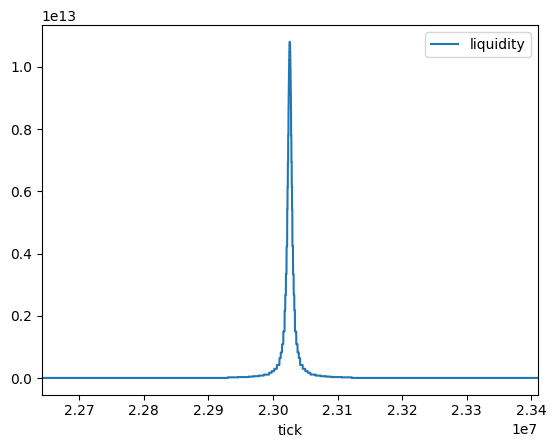

In [29]:
# max half width
df_cleaned.plot(x='tick', y='liquidity', xlim=(TICK_MIN_LIMIT, TICK_MAX_LIMIT))

<Axes: xlabel='tick'>

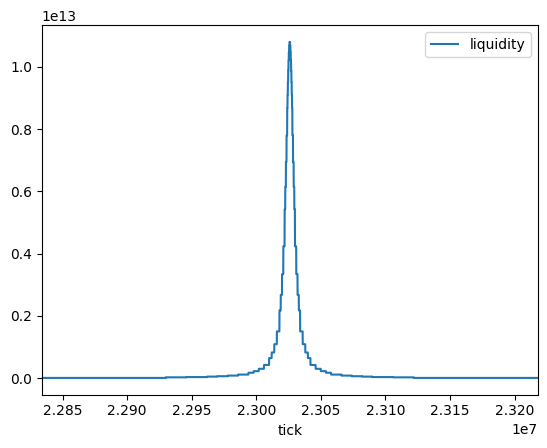

In [30]:
# max half width // 2
df_cleaned.plot(x='tick', y='liquidity', xlim=(TICK_CENTER - TICK_HALF_WIDTH_LIMIT // 2, TICK_CENTER + TICK_HALF_WIDTH_LIMIT // 2))

<Axes: xlabel='tick'>

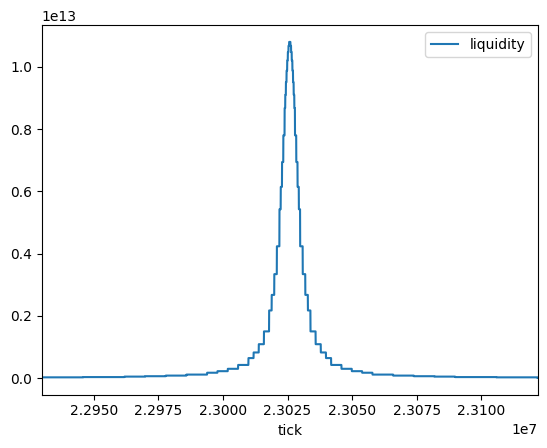

In [31]:
# max half width // 4
df_cleaned.plot(x='tick', y='liquidity', xlim=(TICK_CENTER - TICK_HALF_WIDTH_LIMIT // 4, TICK_CENTER + TICK_HALF_WIDTH_LIMIT // 4))

<Axes: xlabel='tick'>

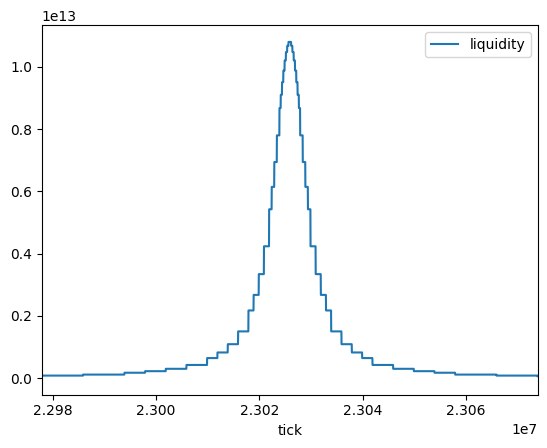

In [32]:
# max half width // 8
df_cleaned.plot(x='tick', y='liquidity', xlim=(TICK_CENTER - TICK_HALF_WIDTH_LIMIT // 8, TICK_CENTER + TICK_HALF_WIDTH_LIMIT // 8))

<Axes: xlabel='tick'>

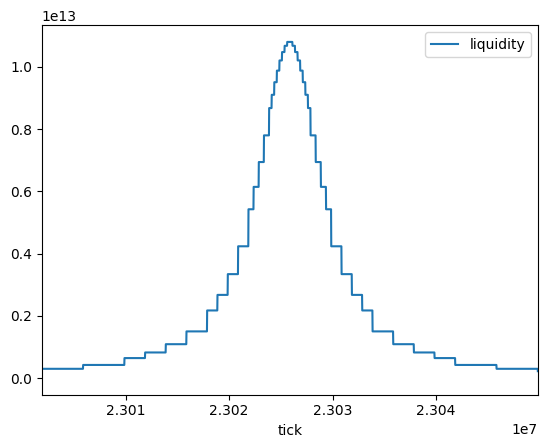

In [33]:
# max half width // 16
df_cleaned.plot(x='tick', y='liquidity', xlim=(TICK_CENTER - TICK_HALF_WIDTH_LIMIT // 16, TICK_CENTER + TICK_HALF_WIDTH_LIMIT // 16))

<Axes: xlabel='tick'>

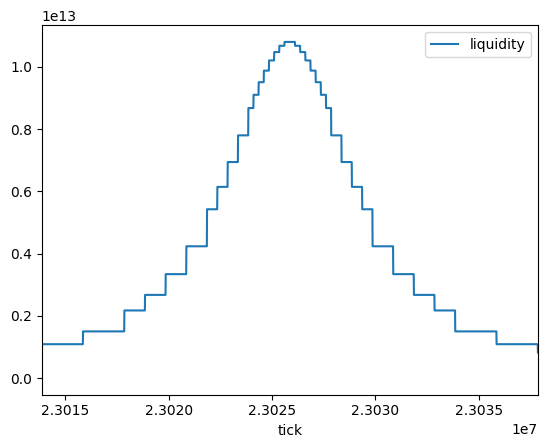

In [34]:
# max half width // 32
df_cleaned.plot(x='tick', y='liquidity', xlim=(TICK_CENTER - TICK_HALF_WIDTH_LIMIT // 32, TICK_CENTER + TICK_HALF_WIDTH_LIMIT // 32))

In [35]:
# normalize by pool liquidity factor
(lf, ) = await lp_contract.functions['pool_liquidity_factor'].call(pool_key)
lf

136067485455972075

In [36]:
GAMMA = 4000
PEG = 128000
mclp = ModifiedCauchyLiquidityProfile(c=lf, gamma=GAMMA, peg=PEG)

In [37]:
df_cleaned['model'] = mclp.at(df_cleaned['tick'] - TICK_CENTER)

In [38]:
# ya so wanna change profile to be bounds of (-x, x + tick_spacing) for each x adding liq to
# given poolState.liquidity is sum of liquidity delta from
# t >= min_tick to t <= poolState.tick (inclusive of liq delta value on positive side)
# which is tilting are current setup slightly
# with new bounds negative liquidity delta less on positive side bound wont get added in until
# after next tick spacing 
df_cleaned

,tick,liquidity,model
0,22641860,10563810274,1.173859e+10
1,22641870,10563810274,1.173865e+10
2,22641880,10563810274,1.173871e+10
3,22641890,10563810274,1.173877e+10
4,22641900,10563810274,1.173883e+10
...,...,...,...
76796,23409820,10563810274,1.173883e+10
76797,23409830,10563810274,1.173877e+10
76798,23409840,10563810274,1.173871e+10
76799,23409850,10563810274,1.173865e+10


<Axes: xlabel='tick'>

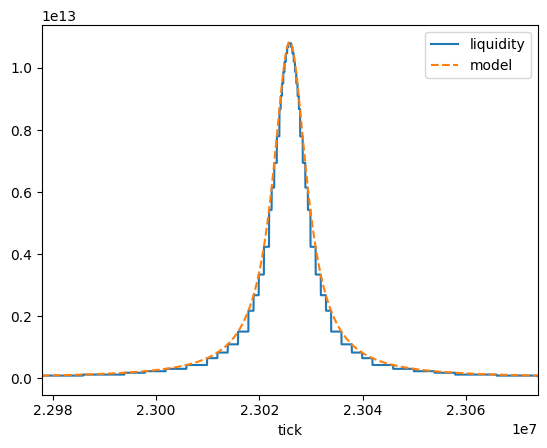

In [39]:
df_cleaned.plot(x='tick', y=['liquidity', 'model'], xlim=(TICK_CENTER - TICK_HALF_WIDTH_LIMIT // 8, TICK_CENTER + TICK_HALF_WIDTH_LIMIT // 8), style=['-', '--'])

<Axes: xlabel='tick'>

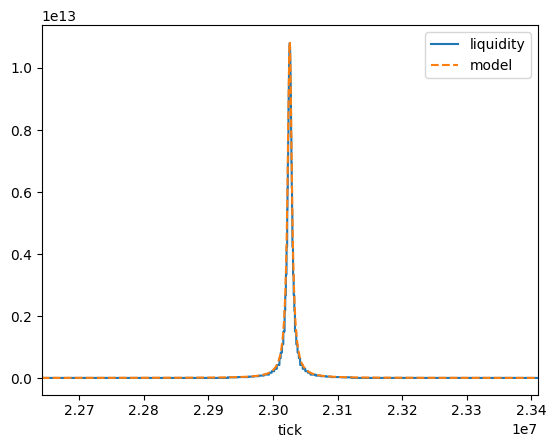

In [40]:
df_cleaned.plot(x='tick', y=['liquidity', 'model'], xlim=(TICK_MIN_LIMIT, TICK_MAX_LIMIT), style=['-', '--'])